# We have a database

Hello, HE2AT team! We now have a database! For For now it is a very minimal example with only one RP1 study available ZAF055. We will soon add MWI198. The database has been created with SQLAlchemy and it is a SQLite database. there are a number of ways to access the database. In python you could us SQLAlchemy itself or you could use DuckDB. This notebook will outline some examples using DuckDB. The same SQL commands could also be use in R.

In [1]:
import fsspec
from pathlib import Path
import shutil

import duckdb
import numpy as np
import pandas as pd

import geopandas as gpd
import intake
import xarray as xr
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fs = fsspec.filesystem("")

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


## Structure

First let's consider the structure of the database. 

In [2]:
# copy the latest layout from our database definition's directory

In [3]:
_ = shutil.copy(Path(Path.home(),'heat_center/data/health_open/database/definition/my_data_model_diagram.svg'), 'my_data_model_diagram.svg')

![SVG Image](my_data_model_diagram.svg)

# Access Data

## Using DuckDB

In [4]:
conn = duckdb.connect(f"{Path(Path.home(),'heat_center/data/health_open/database/data/RP1.db')}")

Let's see which studies are present

In [5]:
query = """
        SELECT s.name
        FROM study s
        INNER JOIN patient p ON s.name = p.study_id;
        """

set(conn.execute(query).fetchall())

{('MWI198',), ('MWI524',), ('ZAF055',)}

and how many patients does this include:

In [6]:
query = """
        SELECT p.patient_id
        FROM patient p
        """

len(conn.execute(query).fetchall())

6923

and what data is available

In [7]:
query_var_names = """
SELECT DISTINCT c.variable_name
FROM codebook c
JOIN variable_data v ON c.variable_name = v.variable_id
"""
var_names_data = conn.execute(query_var_names).fetchall()
[x[0] for x in var_names_data]

['Location',
 'Race',
 'Age-Years',
 'HIV Status',
 'Highly Active Antiretroviral Therapy',
 'Birth Date',
 'Preterm Birth',
 'Birth Weight',
 'Gestational Age at Birth (weeks)',
 'Apgar Score',
 'Sex',
 'Noncompliance with antiretroviral medication regimen (finding)',
 'Alcohol Abuse',
 'Death Indicator',
 'Perinatal Mortality ',
 'CD4 Expressing Cell Count',
 'HIV Viral Load Measurement',
 'Body Weight',
 'Height',
 'Body Mass Index',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'Delivery Procedure',
 'Adverse Event',
 'Smoking Status',
 'Number of Fetuses',
 'Hospitalization',
 'Gastroenteritis',
 'Pneumonia ',
 'Upper Respiratory Tract Infection',
 'Employment Status',
 'Syphilis',
 'Hypertension',
 'Malaria',
 'Tuberculosis',
 'Hypertension-Associated Pregnancy Disorder',
 'Antepartum Hemorrhage',
 'Eclampsia',
 'Placental Abruption',
 'postpartum hemorrhage',
 'placenta praevia',
 'GAIA Level 3b Assessment of Gestational Age',
 'Low Birth Weight',
 'Neonatal Sepsis',

Birth Weight is the easiest to check the quality of our data, let's get the mean 

In [8]:
# Define the variable_id
variable_id = 'Birth Weight'

# Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
query = f"""
SELECT * FROM variable_data WHERE variable_id = '{variable_id}'
"""

# Execute the SQL query and fetch a pandas df
df = conn.execute(query).fetchdf()

In [9]:
df.head()

,id,patient_id,variable_id,date,time,transformed,relation,study,table,source_variable_id,source_value_type,string_source_value,integer_source_value,float_source_value,source_encoding,transformation_instruction,data_type,string_value,integer_value,float_value
0,24015,1eb15e7a348a47e03e08063728ff846a56f91aa0c40dc7...,Birth Weight,2015-07-23,NaN,1,Mother,ZAF055,ZAF055,WeightatBirth,float,NaN,NaN,3.2,NaN,x * 1000,int,NaN,3200,NaN
1,24016,5b5aa4da0d67c22b4b22dffd498a8b7d88d0c718382d74...,Birth Weight,2015-10-15,NaN,1,Mother,ZAF055,ZAF055,WeightatBirth,float,NaN,NaN,3.2,NaN,x * 1000,int,NaN,3200,NaN
2,24017,b4ec5af3168edc57458fb52634c0736572cdcb5fb9ef54...,Birth Weight,2015-08-25,NaN,1,Mother,ZAF055,ZAF055,WeightatBirth,float,NaN,NaN,3.1,NaN,x * 1000,int,NaN,3100,NaN
3,24018,d92022ad8c0bb829d452b8db1760ec1aee10a6a1803ea4...,Birth Weight,2016-02-27,NaN,1,Mother,ZAF055,ZAF055,WeightatBirth,float,NaN,NaN,3.7,NaN,x * 1000,int,NaN,3700,NaN
4,24019,1bf498e659d280b7b82f2cd3a32f194c5cadd23ba79d5f...,Birth Weight,2016-02-25,NaN,1,Mother,ZAF055,ZAF055,WeightatBirth,float,NaN,NaN,2.9,NaN,x * 1000,int,NaN,2900,NaN


In [10]:
df['integer_value'].mean()

2918.515205724508

and max? obvs a mistake

In [11]:
df['integer_value'].max()

5200

In [12]:
df['integer_value'].min()

1000

Maybe even a plot

<Axes: ylabel='Frequency'>

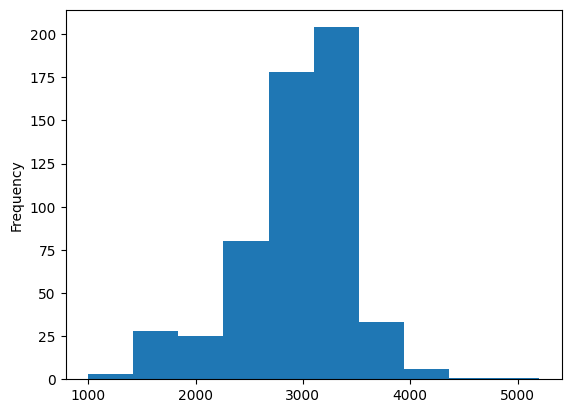

In [13]:
df['integer_value'].plot.hist() 

which studies do these come from?

In [14]:
set(df.study) 

{'ZAF055'}

Just the one

Or a catagorical dataset

In [15]:
from collections import Counter

data = conn.execute("SELECT * FROM variable_data WHERE variable_id = 'Delivery Procedure'").fetchall()
Counter([x[-3] for x in data]) 

Counter({'Natural': 1491,
         'C-section': 162,
         'vaginal': 1422,
         'assisted': 3,
         'operative': 7})

Apgar score is perhaps the easiest to relate to climate data so let's do a dry run of this

In [16]:
# Define the variable_id
variable_id = 'Apgar Score'

# Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
query = f"""
SELECT * FROM variable_data WHERE variable_id = '{variable_id}'
"""

# Execute the SQL query and fetch a pandas df
df = conn.execute(query).fetchdf()

df = df.drop(columns = 'id').drop_duplicates()  # this is dropping rows with all cols identical, not sure why duplicates are present 

In [17]:
df = df[['patient_id','integer_value']]
df = df.rename(columns = {'integer_value':'apgar_score'})

In [18]:
df

,patient_id,apgar_score
0,1eb15e7a348a47e03e08063728ff846a56f91aa0c40dc7...,10
1,5b5aa4da0d67c22b4b22dffd498a8b7d88d0c718382d74...,10
2,b4ec5af3168edc57458fb52634c0736572cdcb5fb9ef54...,10
3,d92022ad8c0bb829d452b8db1760ec1aee10a6a1803ea4...,10
4,1bf498e659d280b7b82f2cd3a32f194c5cadd23ba79d5f...,10
...,...,...
538,e41997bf0ba6d824efe8956b490646e98a8a39994ed6e3...,10
539,a3e37e8de95a8a769d5fe98151578ec8e226d7b4d25803...,10
540,a1d9e7d2544539d7294718017e0d49a758e8394de987b7...,10
541,7aee27e4090e6cb3e75e76ee5945653e35b10994bf88ab...,10


There is no date explicitely mapped but we know this is measured at birth 

In [19]:
# Define the variable_id
variable_id = 'Birth Date'

# Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
query = f"""
SELECT * FROM variable_data WHERE variable_id = '{variable_id}'
"""

# Execute the SQL query and fetch a pandas df
birth_date_df = conn.execute(query).fetchdf()

birth_date_df = birth_date_df.drop(columns = 'id').drop_duplicates() # not sure why duplicates??

In [20]:
birth_date_df

,patient_id,variable_id,date,time,transformed,relation,study,table,source_variable_id,source_value_type,string_source_value,integer_source_value,float_source_value,source_encoding,transformation_instruction,data_type,string_value,integer_value,float_value
0,1eb15e7a348a47e03e08063728ff846a56f91aa0c40dc7...,Birth Date,NaN,NaN,1,Mother,ZAF055,ZAF055,inf0203,NaN,NaN,NaN,NaN,NaN,NaN,datetime,2015-07-23,NaN,NaN
1,5b5aa4da0d67c22b4b22dffd498a8b7d88d0c718382d74...,Birth Date,NaN,NaN,1,Mother,ZAF055,ZAF055,inf0203,NaN,NaN,NaN,NaN,NaN,NaN,datetime,2015-10-15,NaN,NaN
2,b4ec5af3168edc57458fb52634c0736572cdcb5fb9ef54...,Birth Date,NaN,NaN,1,Mother,ZAF055,ZAF055,inf0203,NaN,NaN,NaN,NaN,NaN,NaN,datetime,2015-08-25,NaN,NaN
3,d92022ad8c0bb829d452b8db1760ec1aee10a6a1803ea4...,Birth Date,NaN,NaN,1,Mother,ZAF055,ZAF055,inf0203,NaN,NaN,NaN,NaN,NaN,NaN,datetime,2016-02-27,NaN,NaN
4,1bf498e659d280b7b82f2cd3a32f194c5cadd23ba79d5f...,Birth Date,NaN,NaN,1,Mother,ZAF055,ZAF055,inf0203,NaN,NaN,NaN,NaN,NaN,NaN,datetime,2016-02-25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,3d661fa0c984f33c025bbb80b4fd89985bc810c8c06378...,Birth Date,2016-12-06,09:45:00,1,Child,MWI524,MWI524,Date_of_Birth,NaN,NaN,NaN,NaN,Direct mapping,NaN,datetime,2016-12-06,NaN,NaN
9945,c184f25708f081e6f31a8b35a595bf1119e72ff5d73470...,Birth Date,2017-01-29,13:00:00,1,Child,MWI524,MWI524,Date_of_Birth,NaN,NaN,NaN,NaN,Direct mapping,NaN,datetime,2017-01-29,NaN,NaN
9946,872a6e1747333fb17d22d503f97becbb7580e76b4ced4e...,Birth Date,2017-02-09,01:46:00,1,Child,MWI524,MWI524,Date_of_Birth,NaN,NaN,NaN,NaN,Direct mapping,NaN,datetime,2017-02-09,NaN,NaN
9947,7c7c624fb30bd4bc81fd10d7c7a82c12f3246e833c4248...,Birth Date,2016-01-31,16:00:00,1,Child,MWI524,MWI524,Date_of_Birth,NaN,NaN,NaN,NaN,Direct mapping,NaN,datetime,2016-01-31,NaN,NaN


In [26]:
date_of_birth = []
for index, row in df.iterrows():
    try:
        date_of_birth.append(birth_date_df[birth_date_df.patient_id == row.patient_id].string_value.item())
    except:
        date_of_birth.append(np.nan)


df['date_of_birth'] = pd.to_datetime(date_of_birth) 
df = df.dropna(how = 'any') # no point keeping data with no date, although could still use as baseline ?

/tmp/ipykernel_13759/411942413.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_of_birth'] = pd.to_datetime(date_of_birth)


Now we need location data 
:

In [27]:
# Define the variable_id
variable_id = 'Location'

# Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
query = f"""
SELECT * FROM variable_data WHERE variable_id = '{variable_id}'
"""

# Execute the SQL query and fetch a pandas df
location_df = conn.execute(query).fetchdf()
location_df = location_df.drop(columns = 'id').drop_duplicates() # not sure why duplicates??

In [28]:
location_df = location_df[location_df.study == 'ZAF055'] 

In [29]:
set(location_df.source_variable_id)

{'DeliveryPlace', 'cliniccode'}

We could subset by births only at clinic but will keep simple, presumably how is close to clinic

In [30]:
set(location_df[location_df.source_variable_id == 'DeliveryPlace'].string_value)

{'Clinic', 'Home', 'Hospital'}

In [31]:
data = conn.execute("SELECT * FROM variable_data WHERE source_variable_id = 'DeliveryPlace'").fetchall()
Counter([x[-3] for x in data]) 

Counter({'Clinic': 276, 'Hospital': 273, 'Home': 4})

very few at home anyway, unclear if hospital location is different to clinicode 

In [32]:
location_df = location_df[location_df.source_variable_id == 'cliniccode'] # not actually necessary

In [33]:
location = []
for index, row in df.iterrows():
    try:
        location.append(location_df[location_df.patient_id == row.patient_id].string_value.item())
    except:
        location.append(np.nan)


df['location'] = location 
df = df.dropna(how = 'any') # no point keeping data with no location

In [34]:
set(df.location)

{'Embalenhle',
 'Empumelelweni',
 'Grootvlei',
 'KwaMhlanga',
 'Lebohang',
 'Paulina M',
 'Phola',
 'Siphosesimbi',
 'Siyathemba',
 'Thembalethu',
 'Vlaklaagte',
 'Winifred Maboa'}

We now need to link these names to a geoegraphic location

In [35]:
input_geojson =  Path(Path.home(), f'heat_center/data/health_open/RP1/ZAF055/geolocation/location.geojson')
gdf = gpd.read_file(input_geojson)
gdf

,Name,Lat,Lon,location_type,country,geometry
0,KwaMhlanga,-25.434771,28.716034,health_facility,ZAF,POINT (28.71603 -25.43477)
1,Siphosesimbi,-25.861806,29.124198,health_facility,ZAF,POINT (29.12420 -25.86181)
2,Empumelelweni,-25.854005,29.105850,health_facility,ZAF,POINT (29.10585 -25.85401)
3,Vlaklaagte,-25.374691,28.860514,health_facility,ZAF,POINT (28.86051 -25.37469)
4,Thembalethu,-25.407015,28.779195,health_facility,ZAF,POINT (28.77920 -25.40702)
5,Phola,-25.157834,31.121585,health_facility,ZAF,POINT (31.12158 -25.15783)
6,Siyathemba,-26.654834,28.606531,health_facility,ZAF,POINT (28.60653 -26.65483)
7,Grootvlei,-26.800736,28.505088,health_facility,ZAF,POINT (28.50509 -26.80074)
8,Embalenhle,-26.539228,29.079530,health_facility,ZAF,POINT (29.07953 -26.53923)
9,Paulina M,-26.562630,29.074431,health_facility,ZAF,POINT (29.07443 -26.56263)


In [36]:
geometry = []
lat = []
lon = []
for index, row in df.iterrows():
    geometry.append(gdf[gdf.Name == row.location].geometry.item())
    lat.append(gdf[gdf.Name == row.location].Lat.item())
    lon.append(gdf[gdf.Name == row.location].Lon.item())
    
df['geometry'] = geometry
df['lat'] = lat
df['lon'] = lon

Let's fetch some climate data

In [37]:
ds = xr.open_mfdataset(Path(Path.home(),f'heat_center/data/climate/reanalysis/rechunk/ERA5-Land/ERA5-Land_tas.zarr'), engine = 'zarr')

and get a sense of scale

In [38]:
list(gdf.total_bounds)

[28.505088, -26.943274, 31.121585, -25.157834]

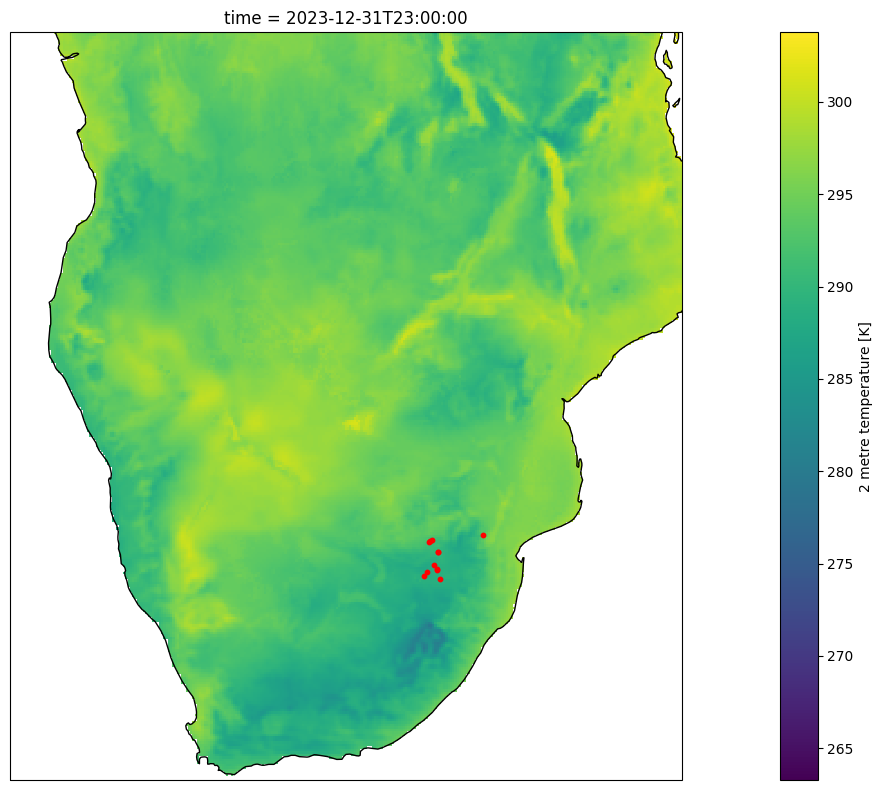

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

axs.add_feature(cfeature.COASTLINE)
axs.set_extent([10, 40, -35, -5], crs=ccrs.PlateCarree())
ds.isel(time = -1).tas.plot(ax = axs)
gdf.plot(ax=axs, marker='o', color='red', markersize=10)

plt.tight_layout()
plt.show()

Nic proposed a while back to create a temperature profile throughout a pregnancy as the integration of the temperature time series experienced during the pregnancy

In [40]:
%%time
ds = ds.sel(latitude = slice(-25,-27), longitude = slice(28,32))
ds = ds.sel(time = slice(str(pd.to_datetime(df.date_of_birth.min()) - pd.Timedelta(weeks = 9*4)), df.date_of_birth.max()))
ds = ds.resample(time='D').max(dim='time')
climatology = ds.groupby('time.dayofyear').mean('time')
ds = ds.groupby('time.dayofyear') - climatology
ds = ds.compute()

CPU times: user 18.6 s, sys: 2.21 s, total: 20.8 s
Wall time: 14.9 s


In [41]:
%%time
temp_profiles = []
for index, row in df.iterrows():
    da = ds.sel(latitude = row.lat, longitude = row.lon, method = 'nearest')
    end = pd.to_datetime(row.date_of_birth) + pd.Timedelta(hours = 12)
    start = end - pd.Timedelta(weeks = 40)
    da = da.sel(time = slice(start, end))
    temp_profiles.append(da.tas.mean(dim = 'time').item())
    
df['temp_profiles'] = temp_profiles

CPU times: user 677 ms, sys: 19.6 ms, total: 696 ms
Wall time: 678 ms


In [42]:
percentile_90 = df['temp_profiles'].quantile(0.9)
subset_top_90 = df[df['temp_profiles'] >= percentile_90]
rest = df[df['temp_profiles'] < percentile_90]

In [43]:
subset_top_90.apgar_score.mean()

9.813953488372093

In [44]:
rest.apgar_score.mean()

9.811023622047244

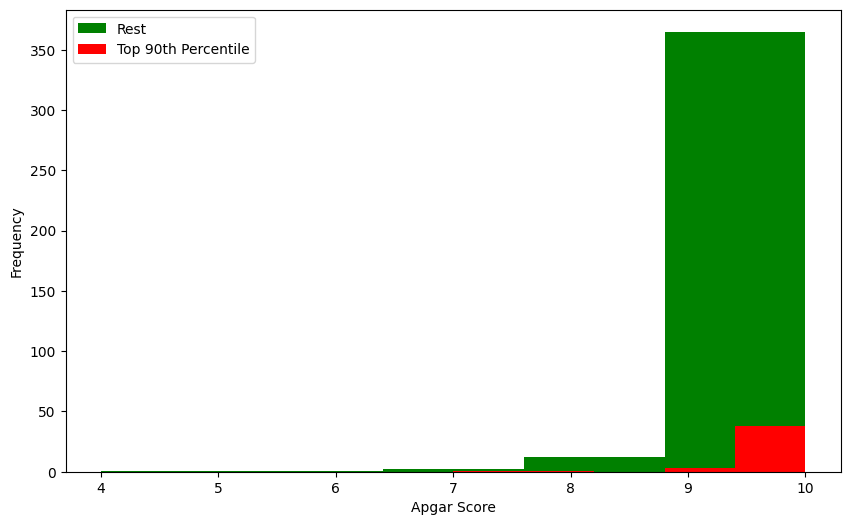

In [45]:
plt.figure(figsize=(10, 6))

plt.hist(rest['apgar_score'], bins=5, color='green', label='Rest')
plt.hist(subset_top_90['apgar_score'], bins=5, color='red', label='Top 90th Percentile')

plt.xlabel('Apgar Score')
plt.ylabel('Frequency')
plt.legend()

This has only been ZAF055 but to confirm data for MWI198 does exist

In [46]:
# Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
query = f"""
SELECT * FROM variable_data WHERE study = 'MWI198'
"""

# Execute the SQL query and fetch a pandas df
df = conn.execute(query).fetchdf()

In [47]:
set(df.variable_id)

{'Adverse Event',
 'Birth Date',
 'Body Weight',
 'Death Indicator',
 'Employment Status',
 'Gastroenteritis',
 'Height',
 'Highly Active Antiretroviral Therapy',
 'Hospitalization',
 'Hypertension',
 'Location',
 'Number of Fetuses',
 'Pneumonia ',
 'Syphilis',
 'Upper Respiratory Tract Infection'}

In [48]:
from collections import Counter

data = conn.execute("SELECT * FROM variable_data WHERE variable_id = 'Gastroenteritis'").fetchall()
Counter([x[-3] for x in data]) 

Counter({'no': 25583, 'yes': 420})

In [49]:
# Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
query = f"""
SELECT * FROM variable_data WHERE study = 'MWI524'
"""

# Execute the SQL query and fetch a pandas df
df = conn.execute(query).fetchdf()

set(df.variable_id)

{'Adverse Event',
 'Antepartum Hemorrhage',
 'Birth Date',
 'Body Weight',
 'CD4 Expressing Cell Count',
 'Congenital Abnormalities',
 'Delivery Procedure',
 'Eclampsia',
 'Employment Status',
 'GAIA Level 3b Assessment of Gestational Age',
 'HIV Viral Load Measurement',
 'Height',
 'Hemoglobin',
 'Highly Active Antiretroviral Therapy',
 'Hypertension',
 'Hypertension-Associated Pregnancy Disorder',
 'Location',
 'Low Birth Weight',
 'Malaria',
 'Neonatal Sepsis',
 'Noncompliance with antiretroviral medication regimen (finding)',
 'Placental Abruption',
 'Preterm Birth',
 'Systolic Blood Pressure',
 'Tuberculosis',
 'placenta praevia',
 'postpartum hemorrhage'}

In [50]:
data = conn.execute("SELECT * FROM variable_data WHERE variable_id = 'Low Birth Weight'").fetchall()
Counter([x[-3] for x in data]) 

Counter({'no': 1439, 'yes': 1})

In [51]:
data = conn.execute("SELECT * FROM variable_data WHERE variable_id = 'Preterm Birth'").fetchall()
Counter([x[-3] for x in data]) 

Counter({'yes': 465, 'no': 4308})

In [52]:
len(data)

4773

In [53]:
Counter([x[7] for x in data]) 

Counter({'ZAF055': 3333, 'MWI524': 1440})

Can we write a function to link location data for both theses studies?

In [54]:
study = 'ZAF055'
variable_id = 'Preterm Birth'
location_source_variable_name = 'cliniccode'

In [55]:
def return_geolocated_df(study, variable_id, location_source_variable_name):
    # Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
    query = f"""
    SELECT * FROM variable_data WHERE variable_id = '{variable_id}' AND study = '{study}'
    """

    # Execute the SQL query and fetch a pandas df
    df = conn.execute(query).fetchdf()
    df = df.drop(columns = 'id').drop_duplicates()  # this is dropping rows with all cols identical, not sure why duplicates are present 
    
    df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

    if df['data_type'].iloc[0] == 'str':
        df = df[['patient_id', 'date', 'string_value']]
        df = df.rename(columns = {'string_value':variable_id})

    # Construct the SQL query to get data_type and fetch integer_value or float_value accordingly
    query = f"""
    SELECT * FROM variable_data WHERE variable_id = 'Location' AND study = '{study}'
    """

    # Execute the SQL query and fetch a pandas df
    location_df = conn.execute(query).fetchdf()
    location_df = location_df.drop(columns = 'id').drop_duplicates() # not sure why duplicates??

    location_df = location_df[location_df.source_variable_id == location_source_variable_name]

    location = []
    for index, row in df.iterrows():
        try:
            location.append(location_df[location_df.patient_id == row.patient_id].string_value.item())
        except:
            location.append(np.nan)


    df['location'] = location 
    df = df.dropna(how = 'any') # no point keeping data with no location

    input_geojson =  Path(Path.home(), f'heat_center/data/health_open/RP1/{study}/geolocation/location.geojson')
    gdf = gpd.read_file(input_geojson)

    geometry = []
    lat = []
    lon = []
    for index, row in df.iterrows():
        geometry.append(gdf[gdf.Name == row.location].geometry.item())
        lat.append(gdf[gdf.Name == row.location].Lat.item())
        lon.append(gdf[gdf.Name == row.location].Lon.item())

    df['geometry'] = geometry
    df['lat'] = lat
    df['lon'] = lon
    df['study'] = study

    return df

In [75]:
df = pd.concat([return_geolocated_df('ZAF055', 'Preterm Birth', 'cliniccode'), return_geolocated_df('MWI524', 'Preterm Birth', '22dec_infant_birtth_Clinic_ID')])

In [80]:
df = df[df.date > '1990'] # fix bug

In [81]:
df.date.min()

'2014-01-01'

In [82]:
%%time
ds = xr.open_mfdataset(Path(Path.home(),f'heat_center/data/climate/reanalysis/rechunk/ERA5-Land/ERA5-Land_tas.zarr'), engine = 'zarr')

ds = ds.sel(time = slice(str(pd.to_datetime(df.date.min()) - pd.Timedelta(weeks = 9*4)), df.date.max()))
ds = ds.resample(time='D').max(dim='time')

climatology = ds.groupby('time.dayofyear').mean('time') # important when considering multiple countries/studies you are just taking a subset from the hottest or coldest geographic region
ds = ds.groupby('time.dayofyear') - climatology

This should rather go location by location to speed things up!

In [84]:
%%time
temp_profile_by_location = {}
for location in list(set(df.location)):
    lat = df[df.location == location].iloc[0].lat
    lon = df[df.location == location].iloc[0].lon
    da = ds.sel(latitude = lat, longitude = lon, method = 'nearest')
    temp_profile_by_location[location] = da.tas.compute()

CPU times: user 3min 44s, sys: 26.3 s, total: 4min 11s
Wall time: 3min 21s


In [94]:
%%time
temp_profiles = []
for index, row in df.iterrows():
    da = temp_profile_by_location[row.location]
    da = da.sel(time = slice(str(pd.to_datetime(df.date.min()) - pd.Timedelta(weeks = 40)), row.date))
    temp_profiles.append(da.mean(dim = 'time').item())
    
df['temp_profiles'] = temp_profiles

CPU times: user 4.43 s, sys: 27.9 ms, total: 4.46 s
Wall time: 4.47 s


Was 22 hours now around 10 mins

In [95]:
len(df)

2228

In [96]:
df.location.value_counts()

location
QECH              549
Limbe             337
Bangwe            257
Ndirande          236
Siyathemba        109
Thembalethu        98
Embalenhle         97
KwaMhlanga         81
Paulina M          78
Phola              63
Chilomoni          60
Vlaklaagte         59
Lebohang           53
Empumelelweni      44
Siphosesimbi       42
Grootvlei          38
Winifred Maboa     27
Name: count, dtype: int64

In [97]:
df

,patient_id,date,Preterm Birth,location,geometry,lat,lon,study,temp_profiles
0,1eb15e7a348a47e03e08063728ff846a56f91aa0c40dc7...,2015-07-23,yes,KwaMhlanga,POINT (28.716034 -25.434771),-25.434771,28.716034,ZAF055,-0.320598
1,5b5aa4da0d67c22b4b22dffd498a8b7d88d0c718382d74...,2015-10-15,no,KwaMhlanga,POINT (28.716034 -25.434771),-25.434771,28.716034,ZAF055,-0.207071
2,b4ec5af3168edc57458fb52634c0736572cdcb5fb9ef54...,2015-08-25,yes,KwaMhlanga,POINT (28.716034 -25.434771),-25.434771,28.716034,ZAF055,-0.263551
3,d92022ad8c0bb829d452b8db1760ec1aee10a6a1803ea4...,2016-02-27,no,KwaMhlanga,POINT (28.716034 -25.434771),-25.434771,28.716034,ZAF055,0.043508
4,1bf498e659d280b7b82f2cd3a32f194c5cadd23ba79d5f...,2016-02-25,no,KwaMhlanga,POINT (28.716034 -25.434771),-25.434771,28.716034,ZAF055,0.043375
...,...,...,...,...,...,...,...,...,...
1435,3d661fa0c984f33c025bbb80b4fd89985bc810c8c06378...,2016-12-06,no,QECH,POINT (35.02 15.8),15.800000,35.020000,MWI524,-0.074178
1436,c184f25708f081e6f31a8b35a595bf1119e72ff5d73470...,2017-01-29,no,QECH,POINT (35.02 15.8),15.800000,35.020000,MWI524,0.009786
1437,872a6e1747333fb17d22d503f97becbb7580e76b4ced4e...,2017-02-09,no,QECH,POINT (35.02 15.8),15.800000,35.020000,MWI524,0.002938
1438,7c7c624fb30bd4bc81fd10d7c7a82c12f3246e833c4248...,2016-01-31,no,Limbe,POINT (35.05 -15.81),-15.810000,35.050000,MWI524,-0.029220


In [98]:
percentile_90 = df['temp_profiles'].quantile(0.90)
subset_top_90 = df[df['temp_profiles'] >= percentile_90]
rest = df[df['temp_profiles'] < percentile_90]

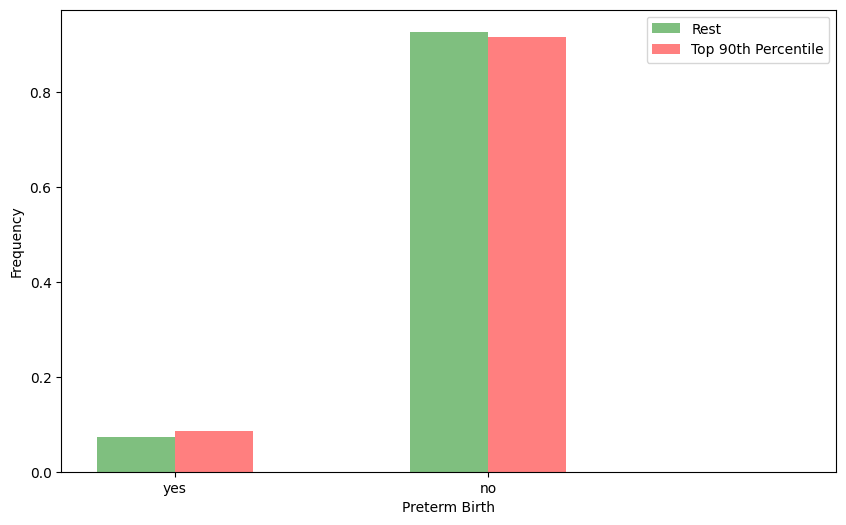

In [99]:
# Create bins for the histograms
bins = np.array([0, 1, 2]) - 0.25  # Adjusted for shifting

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(rest['Preterm Birth'], bins=bins, color='green', density = True, label='Rest', alpha=0.5, width=0.25, align='left')
plt.hist(subset_top_90['Preterm Birth'], bins=bins+0.25, color='red', density = True, label='Top 90th Percentile', alpha=0.5, width=0.25, align='left')

# Add labels and legend
plt.xlabel('Preterm Birth')
plt.ylabel('Frequency')
plt.legend()

# Adjust x-axis labels to show categories
plt.xticks([-0.5, 0.5], ['yes', 'no'])

# Show the plot
plt.show()

In [100]:
import seaborn as sns

/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


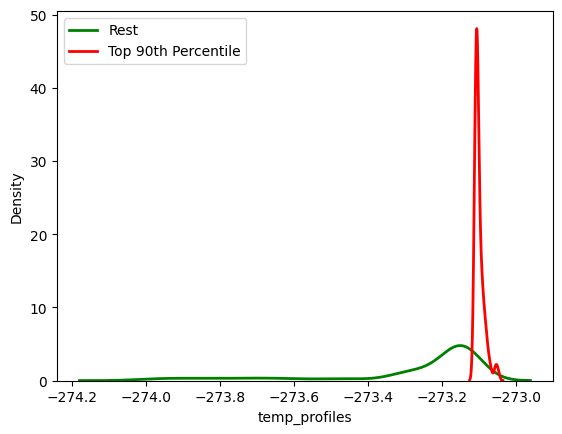

In [101]:
sns.kdeplot(rest['temp_profiles'] - 273.15, lw = 2, color = 'green', label='Rest')
sns.kdeplot(subset_top_90['temp_profiles'] - 273.15, lw = 2, color = 'red', label='Top 90th Percentile')

plt.legend()

In [102]:
percentile_10 = df['temp_profiles'].quantile(0.10)
subset_bottom_10 = df[df['temp_profiles'] <= percentile_10]
rest = df[df['temp_profiles'] > percentile_10]

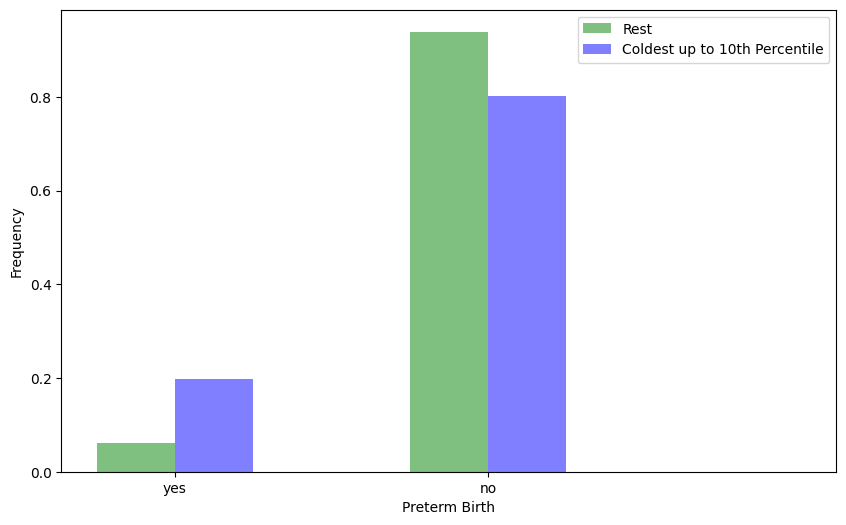

In [103]:
# Create bins for the histograms
bins = np.array([0, 1, 2]) - 0.25  # Adjusted for shifting

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(rest['Preterm Birth'], bins=bins, color='green', density = True, label='Rest', alpha=0.5, width=0.25, align='left')
plt.hist(subset_bottom_10['Preterm Birth'], bins=bins+0.25, color='blue', density = True, label='Coldest up to 10th Percentile', alpha=0.5, width=0.25, align='left')

# Add labels and legend
plt.xlabel('Preterm Birth')
plt.ylabel('Frequency')
plt.legend()

# Adjust x-axis labels to show categories
plt.xticks([-0.5, 0.5], ['yes', 'no'])

# Show the plot
plt.show()

/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


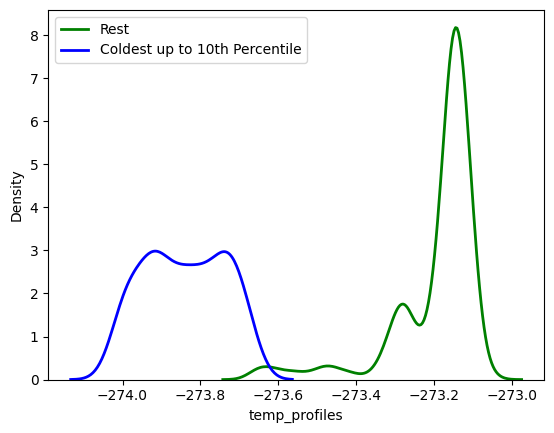

In [104]:
sns.kdeplot(rest['temp_profiles'] - 273.15, lw = 2, color = 'green', label='Rest')
sns.kdeplot(subset_bottom_10['temp_profiles'] - 273.15, lw = 2, color = 'blue', label='Coldest up to 10th Percentile')

plt.legend()

## SQLAlchemy

The database can alse be accesd via the SQLAlchemy ORM. I prefer sql but your mileage may vary....

In [64]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import sys
sys.path.insert(1, '/terra/projects/heat_center/data/health_open/database/definition')
from HE2AT_data_model_definition import Base, Codebook, VariableData, Study, Patient

In [65]:
# Create the database engine and session
engine = create_engine(f"sqlite:///{(Path(Path.home(),'heat_center/data/health_open/database/data/RP1.db'))}")
Session = sessionmaker(bind=engine)
session = Session()

In [66]:
# Get all available variable names from codebook that have associated data in variable_data
filtered_var_names = session.query(Codebook.variable_name.distinct()) \
    .join(VariableData, Codebook.variable_name == VariableData.variable_id) \
    .all()

In [67]:
filtered_var_names

[('Birth Date',),
 ('Age-Years',),
 ('Race',),
 ('Sex',),
 ('Height',),
 ('Body Weight',),
 ('Body Mass Index',),
 ('Location',),
 ('Smoking Status',),
 ('Alcohol Abuse',),
 ('Employment Status',),
 ('Hypertension',),
 ('Delivery Procedure',),
 ('Number of Fetuses',),
 ('Preterm Birth',),
 ('Gestational Age at Birth (weeks)',),
 ('Birth Weight',),
 ('Apgar Score',),
 ('Death Indicator',),
 ('Perinatal Mortality ',),
 ('Hospitalization',),
 ('Gastroenteritis',),
 ('Pneumonia ',),
 ('Syphilis',),
 ('HIV Status',),
 ('HIV Viral Load Measurement',),
 ('CD4 Expressing Cell Count',),
 ('Highly Active Antiretroviral Therapy',),
 ('Noncompliance with antiretroviral medication regimen (finding)',),
 ('Upper Respiratory Tract Infection',),
 ('Adverse Event',),
 ('Systolic Blood Pressure',),
 ('Diastolic Blood Pressure',)]

In [68]:
session.query(Study.name).all()

[('ZAF055',),
 ('MWI198',),
 ('MWI088',),
 ('MWI026',),
 ('MWI021',),
 ('MWI094',),
 ('ZAF124',),
 ('MWI524',),
 ('ZAF357',),
 ('ZAF014',),
 ('MUL140',),
 ('MUL159',),
 ('MWI049',),
 ('KEN539',),
 ('ZAF192',),
 ('KEN086',),
 ('TZA556',),
 ('ZAF155',),
 ('MWI097',),
 ('MWI532',),
 ('ZAF358',),
 ('MUL006',)]